In [1]:
# 在 notebook 第一格執行
%pip uninstall -y tensorflow keras keras-nightly keras-Preprocessing keras-vis h5py
%pip uninstall -y protobuf numpy ml_dtypes
%pip install numpy==1.24.3 protobuf==3.20.3 ml_dtypes==0.2.0
%pip install tensorflow==2.15.0


Found existing installation: h5py 3.7.0
Uninstalling h5py-3.7.0:
  Successfully uninstalled h5py-3.7.0
Note: you may need to restart the kernel to use updated packages.
Found existing installation: protobuf 4.21.7
Uninstalling protobuf-4.21.7:
  Successfully uninstalled protobuf-4.21.7
Found existing installation: numpy 1.23.3
Uninstalling numpy-1.23.3:
  Successfully uninstalled numpy-1.23.3
Note: you may need to restart the kernel to use updated packages.
  Using cached numpy-1.24.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Using cached protobuf-3.20.3-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.0 MB)
  Using cached ml_dtypes-0.2.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.2 requires numpy<1.24,>=1.18, but you have numpy 1.24.3 which is in

In [2]:
from IPython.display import display
import os

# 上傳檔案（會跳出檔案選擇器）
from ipywidgets import FileUpload

upload = FileUpload()
display(upload)


FileUpload(value=(), description='Upload')

In [3]:
import os
from pathlib import Path

# 假設你只上傳了一個檔案
fileinfo = upload.value[0]  # 通常是一個 dict，含 'name' 和 'content'

# 顯示內容結構（除錯用）
print(fileinfo)

# 儲存 kaggle.json
filename = fileinfo['name']
content = fileinfo['content']

kaggle_dir = Path.home() / ".kaggle"
kaggle_dir.mkdir(exist_ok=True)

kaggle_json_path = kaggle_dir / "kaggle.json"
with open(kaggle_json_path, "wb") as f:
    f.write(content)

# 設定權限（Linux/macOS 建議）
os.chmod(kaggle_json_path, 0o600)

print(f"{filename} 已成功儲存至 {kaggle_json_path}")


IndexError: tuple index out of range

In [ ]:
!kaggle datasets list -s cifar


In [ ]:
!pip install -U kaggle
!pip install --upgrade pandas
import os
import zipfile

# 建立 Kaggle 資料夾
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 下載 Dog Breed Identification 資料集
!kaggle competitions download -c dog-breed-identification --force
!unzip -oq dog-breed-identification.zip -d dog-breed-identification


import pandas as pd
import numpy as np

labels = pd.read_csv('dog-breed-identification/labels.csv')

In [1]:
import os
import shutil
import pandas as pd
from PIL import Image
from tqdm import tqdm
# 讀取標籤
labels = pd.read_csv('dog-breed-identification/labels.csv')
# 建立目標輸出資料夾
output_dir = "dog_images"
train_dir = os.path.join(output_dir, "train")
os.makedirs(train_dir, exist_ok=True)

# 根據標籤將圖片存入對應資料夾
def organize_train_images(labels): # Pass labels as an argument
    src_img_dir = "dog-breed-identification/train"
    for idx, row in tqdm(labels.iterrows(), total=len(labels)):
        img_id = row['id']
        breed = row['breed']
        src_path = os.path.join(src_img_dir, img_id + ".jpg")

        # 建立品種對應資料夾
        breed_dir = os.path.join(train_dir, breed)
        os.makedirs(breed_dir, exist_ok=True)

        dst_path = os.path.join(breed_dir, img_id + ".jpg")
        shutil.copyfile(src_path, dst_path)

# Load labels outside the function
labels = pd.read_csv('dog-breed-identification/labels.csv')
organize_train_images(labels) # Call the function with labels argument

/opt/conda/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
100%|██████████| 10222/10222 [00:48<00:00, 211.36it/s]


In [2]:
# 自定義 Dataset 類別
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

class DogBreedImageFolder(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # 建立類別對應表：品種 → 數值 label
        class_names = sorted(os.listdir(root_dir))
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

        for class_name in class_names:
            class_folder = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_folder):
                continue
            for filename in os.listdir(class_folder):
                if filename.endswith(('.jpg', '.png')):
                    self.image_paths.append(os.path.join(class_folder, filename))
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


In [3]:
# 定義 Transform
from torchvision.transforms import RandomResizedCrop, RandomHorizontalFlip, ColorJitter, RandomRotation, ToTensor, Normalize

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),  # 隨機縮放裁切
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),  # 使用 ImageNet 的 mean/std
                         (0.229, 0.224, 0.225)),
])


test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3),
])


In [5]:
#建立 Dataset 與切分
from torch.utils.data import random_split, DataLoader
import collections

# 讀取分類後資料
dataset = DogBreedImageFolder("dog_images/train", transform=train_transform)
# 取得所有類別名稱，需排序以符合 submission 格式
all_breeds = sorted(dataset.class_to_idx.keys())

# 建立 mapping
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
# 計算資料數量與切分比例
val_ratio = 0.2
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 測試集 Dataset（未提供 labels.csv 的 test set 可略過）
# test_dataset = DogBreedImageFolder("dog_images/test", transform=test_transform)

# 檢查各類資料數量
train_labels = [label for _, label in train_dataset]
val_labels = [label for _, label in val_dataset]
print("Train label distribution:", collections.Counter(train_labels))
print("Val label distribution:", collections.Counter(val_labels))


Train label distribution: Counter({97: 98, 11: 97, 42: 94, 1: 93, 73: 92, 100: 92, 87: 91, 94: 91, 26: 90, 61: 89, 52: 88, 6: 86, 7: 86, 9: 86, 69: 84, 3: 83, 75: 81, 59: 80, 95: 79, 30: 79, 68: 78, 80: 78, 13: 77, 84: 76, 86: 76, 35: 76, 88: 76, 102: 75, 109: 75, 78: 75, 33: 75, 10: 75, 101: 75, 92: 74, 70: 73, 17: 73, 60: 73, 93: 73, 39: 72, 90: 72, 15: 71, 82: 71, 98: 71, 63: 70, 57: 70, 114: 70, 55: 69, 56: 69, 117: 69, 2: 69, 19: 69, 28: 69, 14: 68, 54: 68, 20: 68, 37: 67, 77: 66, 118: 66, 8: 66, 115: 66, 79: 66, 40: 65, 116: 65, 76: 65, 62: 65, 96: 65, 32: 64, 21: 64, 12: 64, 81: 64, 74: 64, 18: 63, 50: 63, 85: 63, 25: 63, 110: 63, 41: 62, 105: 62, 16: 62, 111: 62, 51: 62, 0: 62, 53: 61, 71: 61, 64: 61, 4: 61, 31: 60, 72: 60, 112: 60, 44: 60, 119: 60, 67: 59, 89: 59, 34: 59, 66: 59, 27: 58, 104: 58, 29: 58, 91: 58, 58: 58, 24: 57, 46: 57, 38: 57, 36: 56, 5: 56, 103: 56, 108: 56, 83: 56, 107: 54, 47: 54, 48: 54, 49: 54, 113: 53, 45: 53, 23: 52, 99: 52, 106: 52, 22: 52, 65: 51, 43:

In [6]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)



In [7]:
#驗證資料載入
# 驗證一個 batch
for images, labels in train_loader:
    print("Images shape:", images.shape)  # [B, 3, 224, 224]
    print("Labels shape:", labels.shape)  # [B]
    break


Images shape: torch.Size([16, 3, 224, 224])
Labels shape: torch.Size([16])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


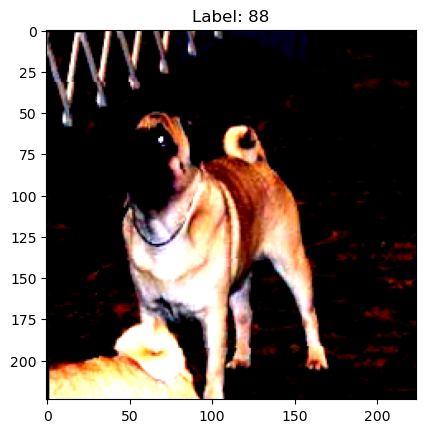

In [8]:
# 如果需要視覺化一個 batch
import matplotlib.pyplot as plt
def show_batch(loader):
    images, labels = next(iter(loader))
    img = images[0].permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(f"Label: {labels[0]}")
    plt.show()

show_batch(train_loader)

In [9]:
import torch
import torch.nn as nn
import torchvision.models as models

num_classes = 120  # Dog Breed Identification 有 120 類別
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 載入預訓練模型並修改最後一層
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# 搬移到裝置（GPU 或 CPU）
model = model.to(device)


In [10]:
num_epochs=120
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)




In [11]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()  # 訓練模式
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # 清零梯度
        optimizer.zero_grad()

        # 前向傳播
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # 反向傳播
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # 計算準確率
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # 更新學習率
    scheduler.step()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    # 在每個 epoch 結束後評估模型在驗證集上的表現
    model.eval()  # 評估模式
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")


Epoch 1/10, Loss: 2.6242, Accuracy: 53.07%
Validation Loss: 1.5398, Validation Accuracy: 75.20%
Epoch 2/10, Loss: 1.5074, Accuracy: 77.95%
Validation Loss: 1.4415, Validation Accuracy: 78.91%
Epoch 3/10, Loss: 1.3189, Accuracy: 83.55%
Validation Loss: 1.4257, Validation Accuracy: 78.57%
Epoch 4/10, Loss: 1.2050, Accuracy: 87.58%
Validation Loss: 1.4138, Validation Accuracy: 79.70%
Epoch 5/10, Loss: 1.1263, Accuracy: 90.33%
Validation Loss: 1.4346, Validation Accuracy: 78.03%
Epoch 6/10, Loss: 1.0744, Accuracy: 92.13%
Validation Loss: 1.5016, Validation Accuracy: 77.79%
Epoch 7/10, Loss: 1.0618, Accuracy: 92.63%
Validation Loss: 1.4763, Validation Accuracy: 78.82%
Epoch 8/10, Loss: 1.0183, Accuracy: 93.93%
Validation Loss: 1.4976, Validation Accuracy: 78.03%
Epoch 9/10, Loss: 0.9907, Accuracy: 95.13%
Validation Loss: 1.5662, Validation Accuracy: 75.98%
Epoch 10/10, Loss: 0.9892, Accuracy: 94.96%
Validation Loss: 1.5107, Validation Accuracy: 77.54%


In [14]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class TestImageDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_filenames = sorted(os.listdir(image_folder))
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.image_folder, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_name.split('.')[0]  # 傳回 image tensor 和 id（去掉 .png/.jpg）

In [20]:
# 建立 DataLoader
# 設定測試資料夾路徑
test_folder = 'dog-breed-identification/test' 
test_dataset = TestImageDataset(test_folder, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
 # 請確認實際位置
results = []
with torch.no_grad():
    for inputs, image_ids in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for img_id, pred in zip(image_ids, preds.cpu()):
            breed = idx_to_class[pred.item()]
            row = {"id": img_id}
            for b in all_breeds:
                row[b] = 1 if b == breed else 0
            results.append(row)

# 輸出為符合要求的 CSV
df = pd.DataFrame(results)
df.to_csv("submission.csv", index=False)
print("✅ submission.csv 轉換完成，可上傳至 Kaggle！")

✅ submission.csv 轉換完成，可上傳至 Kaggle！
